Objective: Evaluate efficient net B0 on CIFAR-10, both as a feature extractor and using transfer learning.

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
# Load and preprocess data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#x_train, x_test = x_train / 255.0, x_test / 255.0  # EfficientNet does not like normalization



In [32]:
from tensorflow.keras.utils import to_categorical
# Convert the output to one-hot vectors
num_classes = 10
y_train = to_categorical(y_train.reshape(-1), num_classes)
y_test = to_categorical(y_test.reshape(-1), num_classes)

cifar10_class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
  ]



### Functions to build and train a model

In [33]:
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

def create_model(isTrainable=False):
  base_model = EfficientNetB0(input_shape=(32,32,3), weights='imagenet', include_top=False)
  base_model.trainable = isTrainable
  model_sequential = models.Sequential([
    # Add the data augmentation layer if you want to use it
    # data_augmentation, # Uncomment this line if you defined data_augmentation

    # Add the EfficientNet base model as a layer
    base_model,

    # Add your custom classification layers
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax') # Assuming 10 classes for CIFAR-10
])

# Compile the model
  model_sequential.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
  return model_sequential;

In [34]:
def train_model(model, batch_size=32, epochs=10):

# Train the model with frozen weights
  history = model.fit(x_train, y_train,
                               batch_size=batch_size,
                               epochs=epochs,
                               validation_split=0.2)
  return history;

### Plotting Functions
Plot model accuray as a function of epochs, plot a confusion matrix, and plot ROC curves

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_accuracy(history):
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_confusion (y_true_classes, y_pred_classes, class_names) :
  # Calculate the confusion matrix
  cm = confusion_matrix(y_true_classes, y_pred_classes)



  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

def plot_roc (y_true_classes, y_pred_probs, num_classes, class_names) :
  # Plot ROC curve for each class
  plt.figure(figsize=(12, 10))

  # Plot ROC curve for each class
  for i in range(num_classes):
    # Get true labels for current class (one-vs-rest)
    y_true_binary = (y_true_classes == i).astype(int)

    # Get predicted probabilities for current class
    y_score_class = y_pred_probs[:, i]

    fpr, tpr, _ = roc_curve(y_true_binary, y_score_class)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

  plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()


###Train and evaluate efficient net feature extraction on CIFAR-10

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1, 1, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.3635 - loss: 1.7966 - val_accuracy: 0.5114 - val_loss: 1.3891
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4882 - loss: 1.4513 - val_accuracy: 0.5333 - val_loss: 1.3106
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5087 - loss: 1.4025 - val_accuracy: 0.5529 - val_loss: 1.2674
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5097 - loss: 1.3878 - val_accuracy: 0.5489 - val_loss: 1.2625
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5105 - loss: 1.3740 - val_accuracy: 0.5624 - val_loss: 1.2395
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5171 - loss: 1.3621 - val_accuracy: 0.5536 - val_loss: 1.2525
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5196 - loss: 1.3498 - val_accuracy: 0.5612 - val_loss: 1.2376
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5195 - loss: 1.3641 

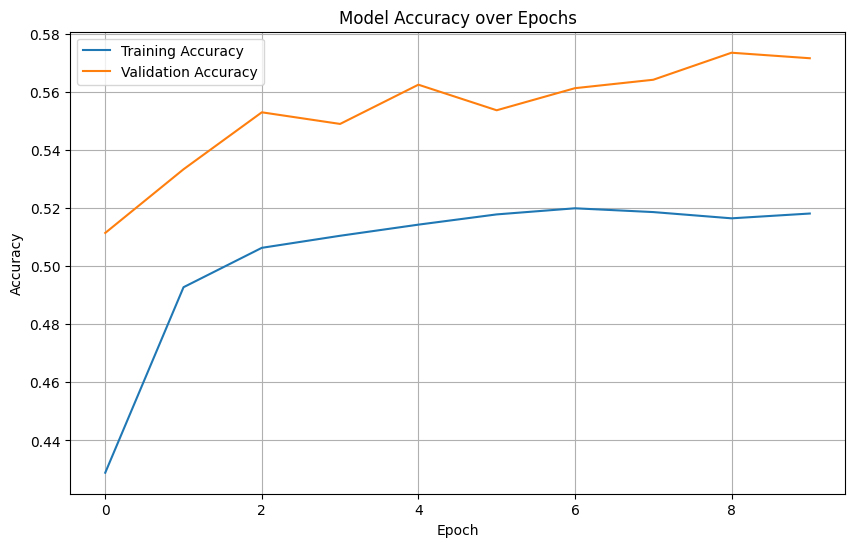

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5689 - loss: 1.2325
Test Loss: 1.2207
Test Accuracy: 0.5718
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step
Predictions generated and labels prepared.


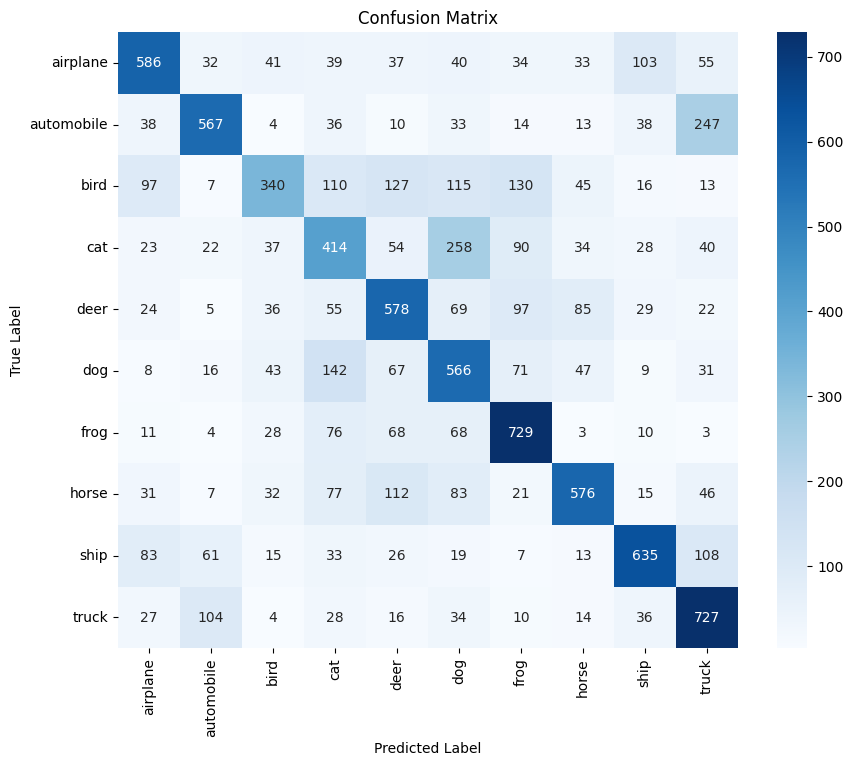

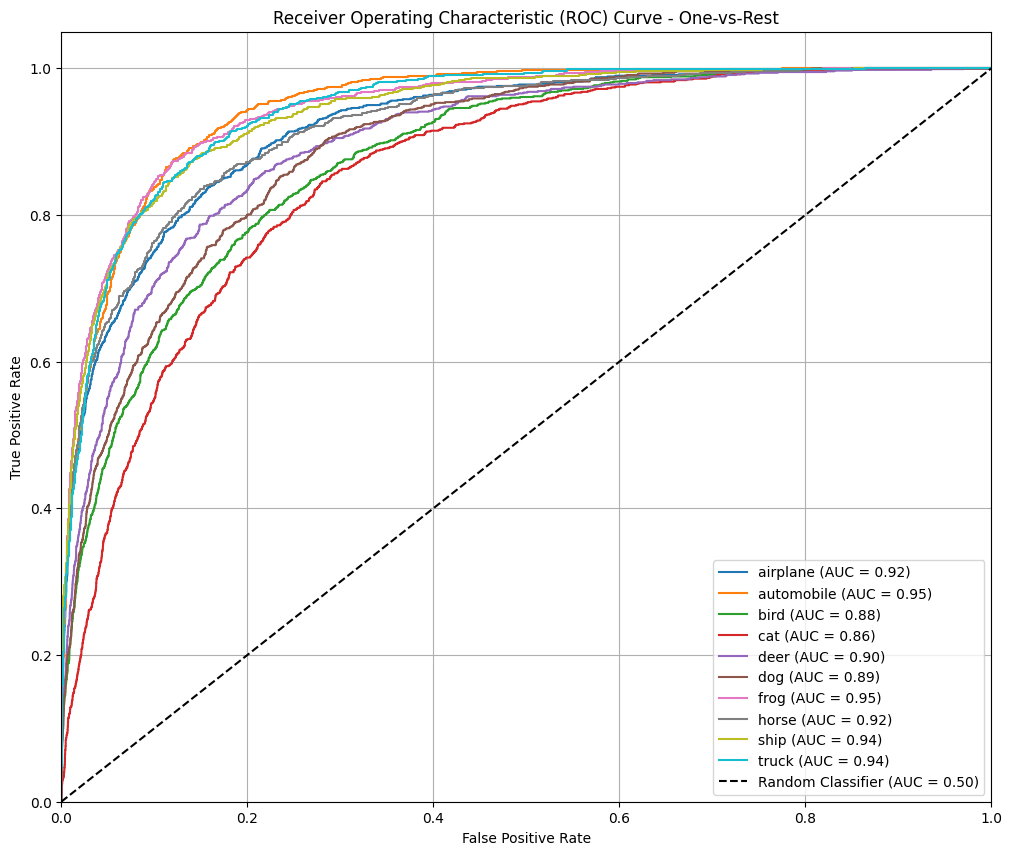

In [36]:
model_sequential = create_model()
model_sequential.summary()
history=train_model(model_sequential)
plot_accuracy(history)
# Evaluate the model on the test set
loss, accuracy = model_sequential.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
# Get predictions from the model
y_pred_probs = model_sequential.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test back to single integer labels for confusion matrix
y_true_classes = np.argmax(y_test, axis=1)

print("Predictions generated and labels prepared.")
plot_confusion(y_true_classes, y_pred_classes, cifar10_class_names)
plot_roc(y_true_classes, y_pred_probs, num_classes, cifar10_class_names)


### Train and evaluate Efficient Net on CIFAR-10 using a transfer learning approach

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1, 1, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 4,020,358 (15.34 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 23ms/step - accuracy: 0.5104 - loss: 1.4732 - val_accuracy: 0.7225 - val_loss: 0.8454
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7466 - loss: 0.7686 - val_accuracy: 0.7886 - val_loss: 0.6358
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7917 - loss: 0.6289 - val_accuracy: 0.8077 - val_loss: 0.5729
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8159 - loss: 0.5553 - val_accuracy: 0.7960 - val_loss: 0.6080
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8457 - loss: 0.4765 - val_accuracy: 0.8147 - val_loss: 0.5651
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8565 - loss: 0.4305 - val_accuracy: 0.8262 - val_loss: 0.5378
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8800 - loss: 0.3591 - val_accuracy: 0.8217 - val_loss: 0.5623
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8869 -

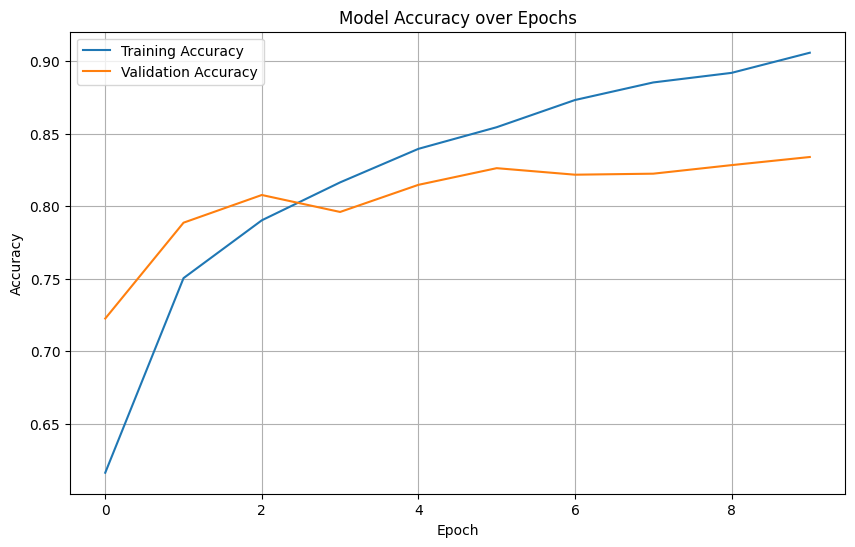

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8192 - loss: 0.6190
Test Loss: 0.5996
Test Accuracy: 0.8238
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step
Predictions generated and labels prepared.


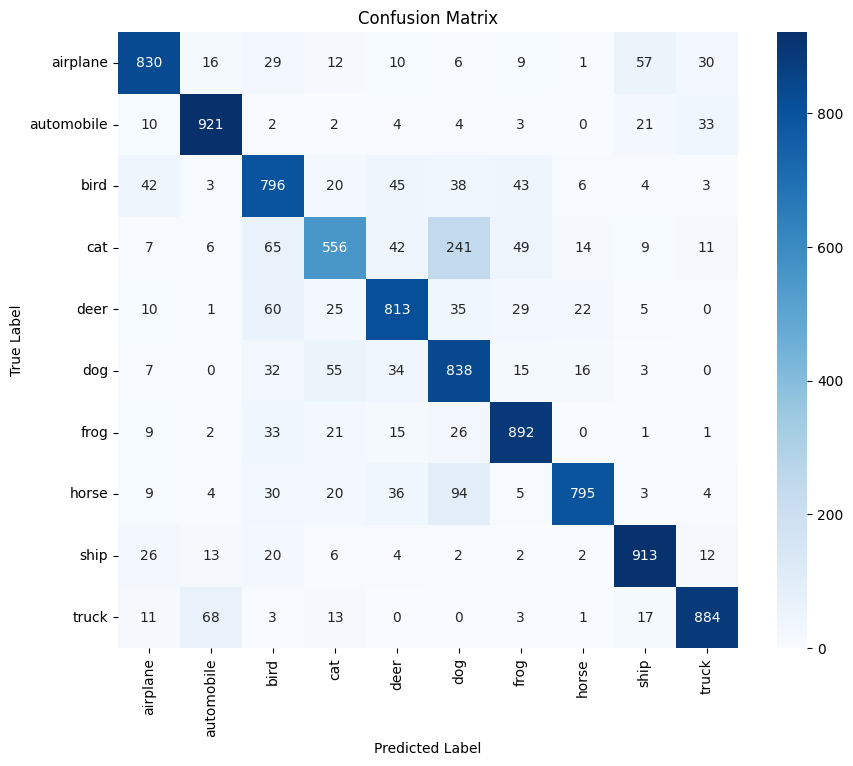

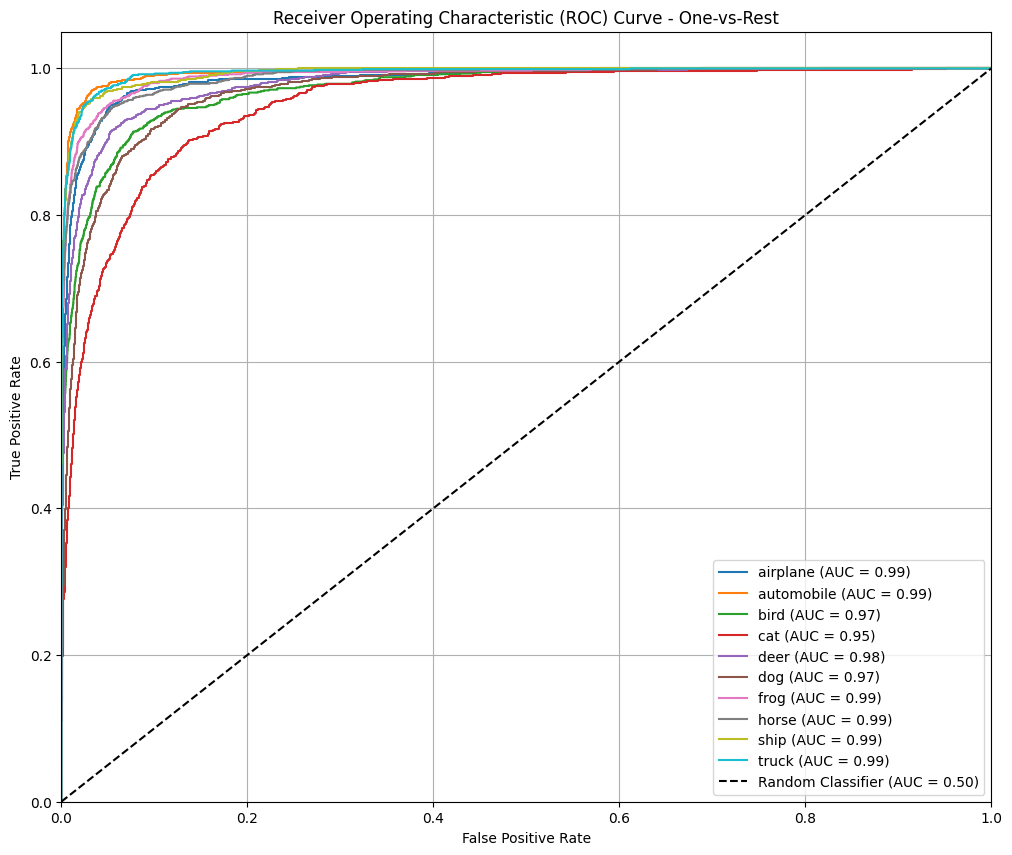

In [37]:
model_sequential = create_model(isTrainable=True)
model_sequential.summary()
history=train_model(model_sequential)
plot_accuracy(history)

# Evaluate the model on the test set
loss, accuracy = model_sequential.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
# Get predictions from the model
y_pred_probs = model_sequential.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test back to single integer labels for confusion matrix
y_true_classes = np.argmax(y_test, axis=1)

print("Predictions generated and labels prepared.")

plot_confusion(y_true_classes, y_pred_classes, cifar10_class_names)
plot_roc(y_true_classes, y_pred_probs, num_classes, cifar10_class_names)
